In [1]:
#!pip install pmdarima -qq

# 주의사항
## pmdarima가 현재(24.11.29) numpy 2.0.0이상 버전과 호환되지 않는다. 
## 따라서 이하 코드는 로컬이 아닌 Google Colab 상에서 돌리는 것을 추천한다.

# 구글 드라이브 연동

In [2]:
'''
from google.colab import drive
drive.mount("/content/drive")
'''

'\nfrom google.colab import drive\ndrive.mount("/content/drive")\n'

# 데이터 불러오기

In [7]:
import pandas as pd

DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/2024/알파코/time_series/data/'
df = pd.read_csv('data/AusAntidiabeticDrug.csv', parse_dates=['ds'])
df.head(10)

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869
5,1991-12-01,4.306371
6,1992-01-01,5.088335
7,1992-02-01,2.814520
8,1992-03-01,2.985811
9,1992-04-01,3.204780


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import STL

# 데이터 시각화
- 시계열 구성요소 확인

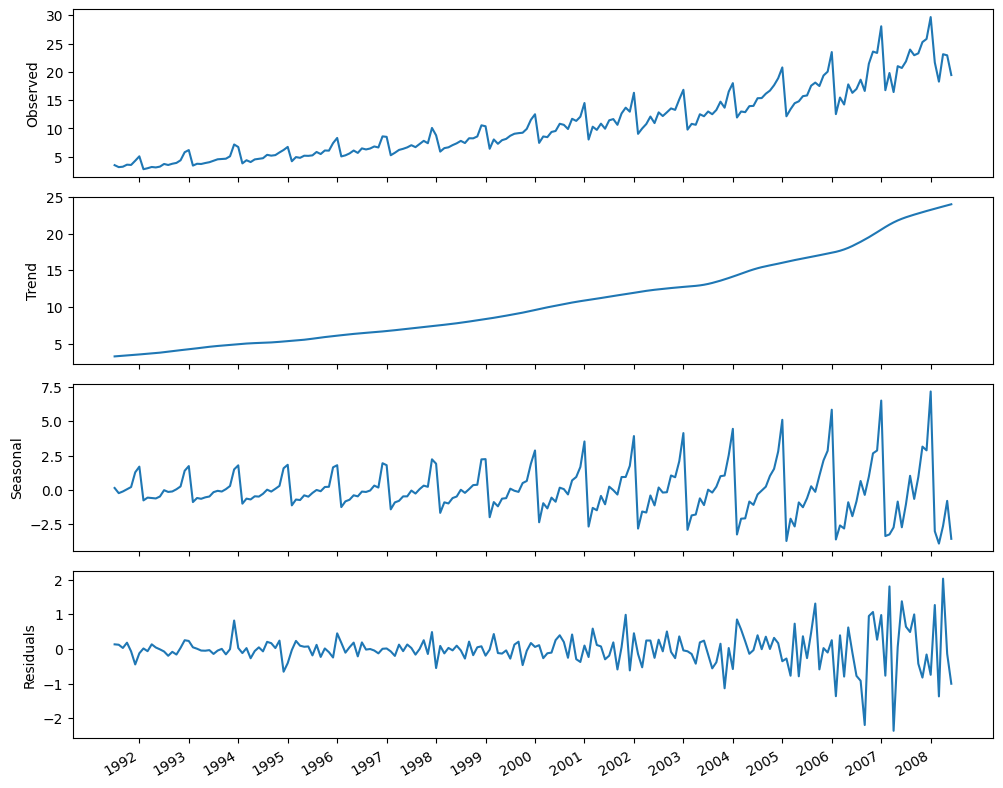

In [9]:
decomposition = STL(df.y, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

# 모델 만들기

## auto_arima 활용

In [10]:
from pmdarima import auto_arima

# auto_arima 모델 설정
auto_model = auto_arima(
    df['y'],                # 대상 데이터(y) 열
    seasonal=True,          # 계절성 SARIMA 활성화
    m=12,                   # 계절 주기 (월별 데이터: 12)
    max_p=5, max_q=5,       # AR(p)와 MA(q)의 최대 차수 설정
    max_P=5, max_Q=5,       # 계절 AR(P)와 MA(Q)의 최대 차수 설정
    max_d=2, max_D=2,       # 차분(d) 및 계절 차분(D)의 최대 차수 설정
    start_p=0, start_q=0,   # AR(p)와 MA(q)의 시작 값
    start_P=0, start_Q=0,   # 계절 AR(P)와 MA(Q)의 시작 값
    stepwise=True,          # 단계별 최적화 활성화 (속도 향상)
    trace=True              # 최적화 과정 출력 활성화
)

# 최적화된 SARIMA 모델 요약 출력
print(auto_model.summary())

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

## 훈련데이터 및 테스트 데이터 분리

In [33]:
train = df.y[:168]
test = df.y[168:]

print(len(test))

36


## 최종 모델 만들기

- Best model:  ARIMA(4,1,1)(0,1,1)[12]

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX

SARIMA_model = SARIMAX(train, order=(4,1,1), seasonal_order=(0,1,1,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  168
Model:             SARIMAX(4, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -130.856
Date:                            Fri, 29 Nov 2024   AIC                            275.712
Time:                                    00:50:09   BIC                            297.016
Sample:                                         0   HQIC                           284.365
                                            - 168                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0342      0.122      0.279      0.780      -0.206       0.274
ar.L2          0.1700      0.119   

## 모형 진단

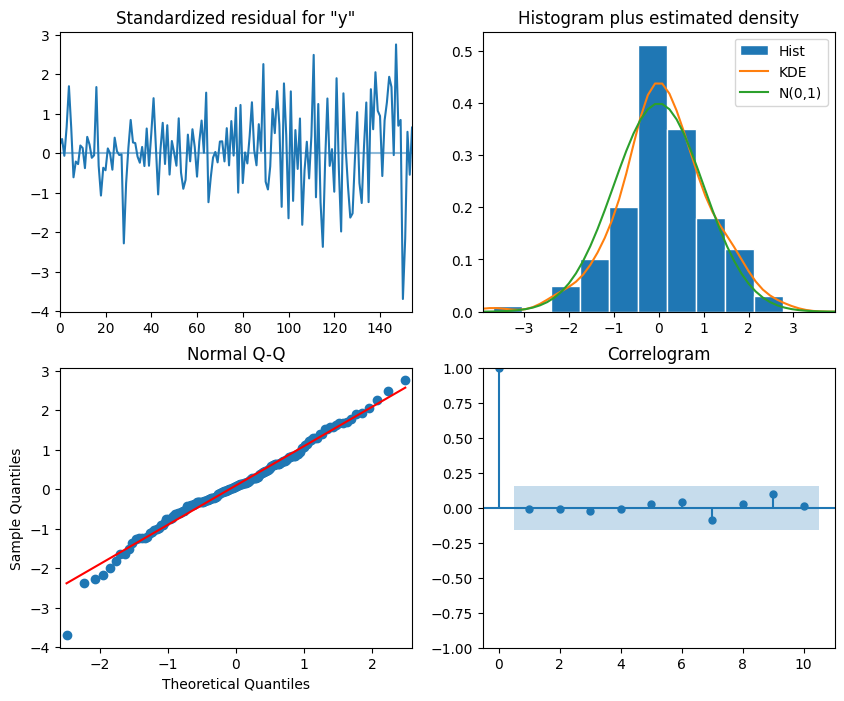

In [35]:
import matplotlib.pyplot as plt
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

plt.show()

In [36]:
import numpy as np
residuals = SARIMA_model_fit.resid

acorr_ljungbox(residuals, np.arange(1, 11, 1))['lb_pvalue']

,lb_pvalue
1,0.489889
2,0.720941
3,0.879226
4,0.917949
5,0.857111
6,0.873330
7,0.250041
8,0.316521
9,0.337324
10,0.411091


## 예측

In [37]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season = []

        for i in range(train_len, total_len, window):
            last_season = df['y'][i-window:i].values
            pred_last_season.extend(last_season)

        return pred_last_season

    elif method == 'SARIMA':
        pred_SARIMA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df['y'][:i], order=(4,1,1), seasonal_order=(0,1,1,12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)

        return pred_SARIMA

In [38]:
TRAIN_LEN = 168
HORIZON = 36
WINDOW = 12

pred_df = df[168:]
pred_df['last_season'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last_season')
pred_df['SARIMA'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')
pred_df

<ipython-input-38-d6eb1894fd11>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['last_season'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last_season')
<ipython-input-38-d6eb1894fd11>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['SARIMA'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')


,ds,y,last_season,SARIMA
168,2005-07-01,15.829550,15.339097,16.723486
169,2005-08-01,17.554701,15.370764,16.475029
170,2005-09-01,18.100864,16.142005,17.413921
171,2005-10-01,17.496668,16.685754,18.048699
172,2005-11-01,19.347265,17.636728,18.483828
173,2005-12-01,20.031291,18.869325,20.099112
174,2006-01-01,23.486694,20.778723,21.885426
175,2006-02-01,12.536987,12.154552,14.066790
176,2006-03-01,15.467018,13.402392,15.247982
177,2006-04-01,14.233539,14.459239,15.911594


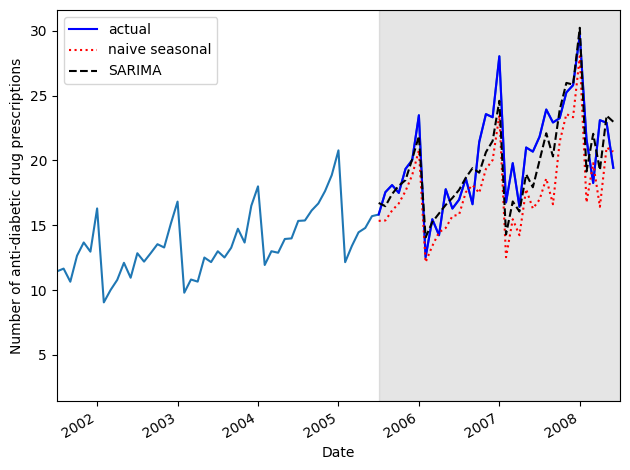

In [39]:
fig, ax = plt.subplots()

ax.plot(df.y)
ax.plot(pred_df.y, 'b-', label='actual')
ax.plot(pred_df.last_season, 'r:', label='naive seasonal')
ax.plot(pred_df.SARIMA, 'k--', label='SARIMA')
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')
ax.axvspan(168, 204, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))
plt.xlim(120, 204)

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## 모델 평가

In [40]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape_naive_seasonal = mape(pred_df.y, pred_df.last_season)
mape_SARIMA = mape(pred_df.y, pred_df.SARIMA)

print(mape_naive_seasonal, mape_SARIMA)

12.686561923100614 8.128399828207487


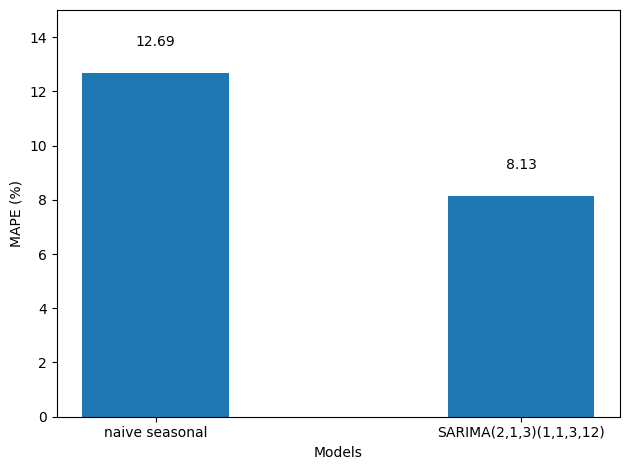

In [41]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'SARIMA(2,1,3)(1,1,3,12)']
y = [mape_naive_seasonal, mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()
plt.show()